### Load libraries

In [1]:
library(beem)
suppressMessages(library(deSolve))  ## for simulation

Loading required package: foreach
Loading required package: doMC
Loading required package: iterators
Loading required package: parallel


### Parameterize the generalized Lotka-Volterra model

In [2]:
set.seed(1)
p <- 10    ## number of species
ntp <- 20  ## number of time points
n <- 15    ## number of subjects
################
alpha <- abs(rnorm(p, 0.2, 0.2)) ## growth parameters
beta <- matrix(0, p, p)     ## interaction matrix
for(j in 1:p){
    temp <- rep(0,p)
    temp[-j] <- rbinom(p-1, 1, 0.3) ## non-self interactions
    temp[which(temp==1)] <- rnorm(sum(temp==1), 0, 0.01)
    beta[j,] <- temp
}
diag(beta) <- -abs(rnorm(p, 0.01, 0.01))
params <- list(alpha=alpha, beta=beta)

### Functions for simulation

In [3]:
## GLV function
glv <- function(t, x, params){
    with(as.list(params, c(x)), {
        dx <- alpha * x + x * (beta %*% x) 
        list(dx)
    })
}
## integration function
integ <- function(t, init.x, model, params){
    ode(init.x, t, model, params)
}

### Simulate time-course data by numerical integration

In [4]:
## simulate absolute abundances
dat <- foreach(i=1:n, .combine=rbind) %do%{
    init.x <- abs(rnorm(p, 0, 10))
    names(init.x) <- sprintf("sp%03d", 1:p)
    out <- integ(0:ntp, init.x, glv, params)
    out[-1,]
}
## relative abundances
relAbun <- prop.table(dat[,-1],1)

### Visualize the abundance trajectories

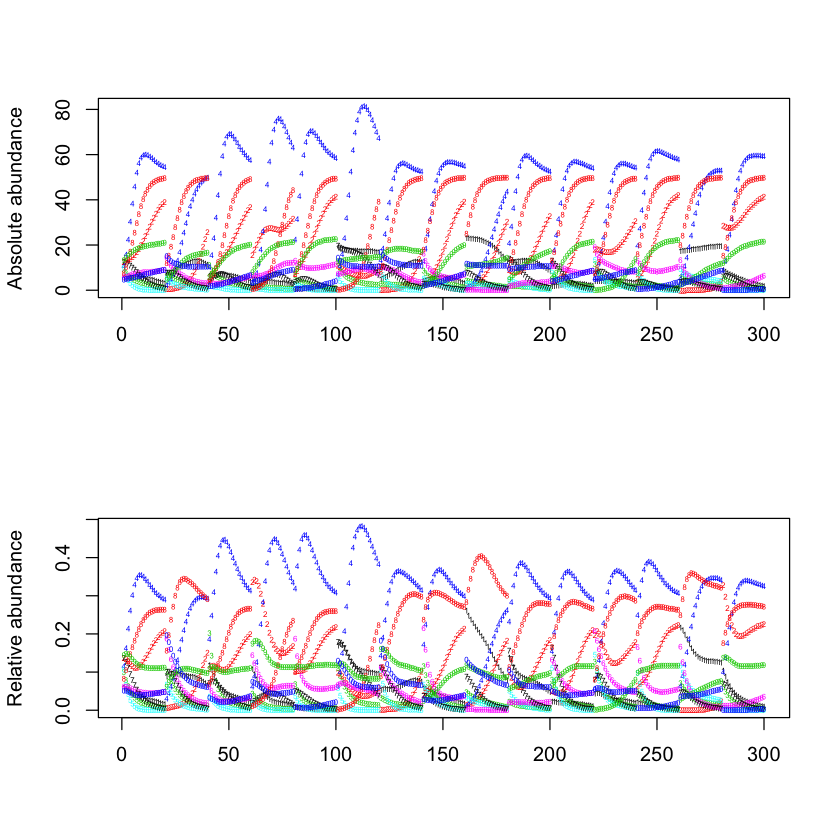

In [5]:
## abundance trajectroy
par(mfrow = c(2,1))
matplot(dat[,-1], ylab='Absolute abundance', cex=0.4)
matplot(relAbun, ylab='Relative abundance', cex=0.4)

### Format the input data for BEEM

In [6]:
## metadata
metadata <- data.frame(sampleID=1:(n*ntp), isIncluded=1, subjectID=rep(1:n, each=ntp), measurementID=1:ntp, 
                       perturbID=0, exptblock=1, intv=c(rep(1,p), rep(-1, n*ntp-p)) ## These are optional
                      )
## counts
counts <- as.data.frame(t(relAbun))

### Run BEEM

In [7]:
res <- EM(dat=counts, meta=metadata, seed = 1, verbose = FALSE, ncpu = 4)

The following species are not recommended due to 0 values:

The following species are not recommended due to their low/high abudances:
sp003, sp004, sp005, sp007, sp010
The following species is recommended as the reference:
sp009
BEEM selecting reference species as default...
Reference species: sp009


### Visualizing the biomass fit

Note that BEEM estimated biomass has a median of a constant (1000 by default). To compare BEEM estimated biomass with the true biomass numerically, they have to be brought to the same scale by scaling their medians to the same (here we multiply BEEM estimated biomass by a constant $c$). Correspondingly, the interaction matrix should also be scaled (by multiplying $\frac{1}{c}$).

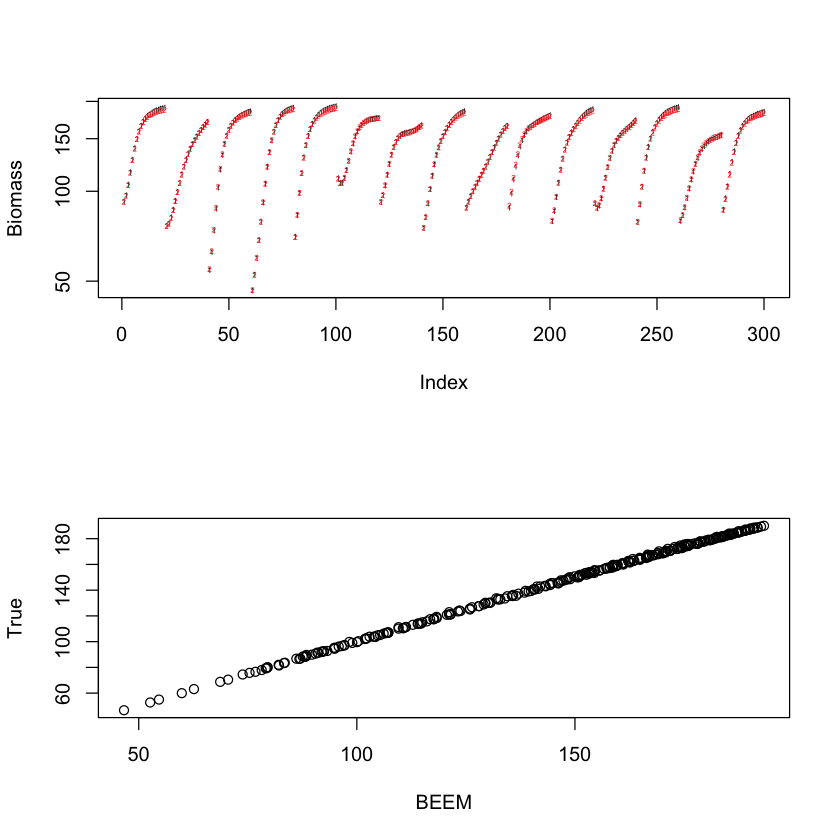

In [8]:
biomassBEEM <- biomassFromEM(res)
biomassTrue <- rowSums(dat[,-1])
scaling <- median(biomassTrue)/median(biomassBEEM) ## scaling constant
par(mfrow = c(2,1))
matplot(cbind(biomassBEEM*scaling, biomassTrue), log='y', xlab='Index', ylab='Biomass',cex=0.4)
plot(cbind(biomassBEEM*scaling, biomassTrue), xlab='BEEM',ylab='True')

### Visualizing the parameter fit

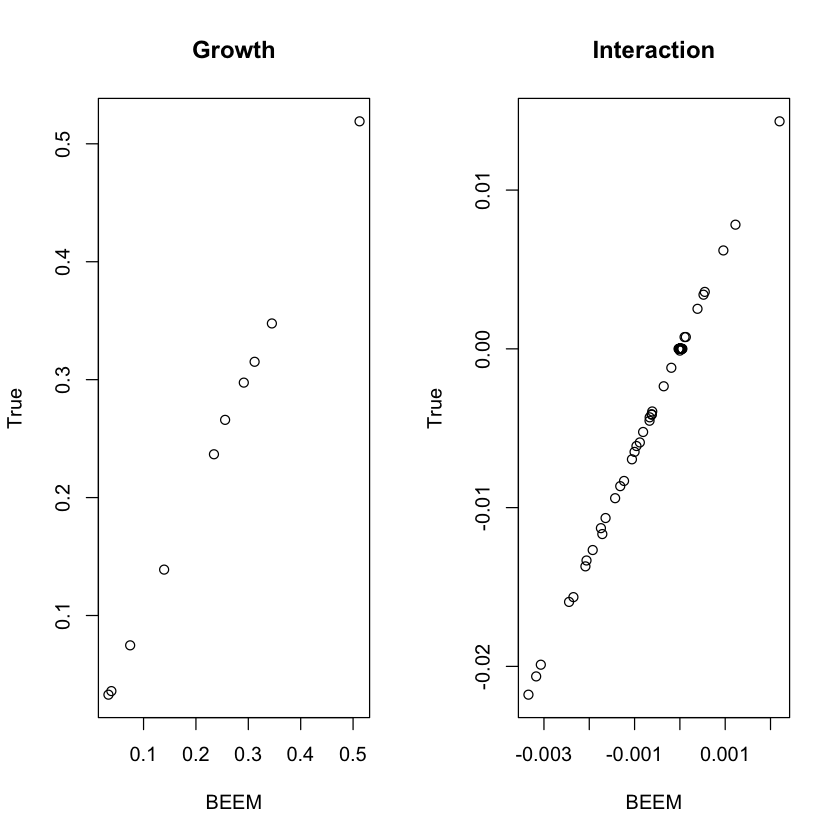

In [9]:
paramBEEM <- paramFromEM(res, counts, metadata) ## compute parameters (with the sparse mode)
par(mfrow = c(1,2))
plot(paramBEEM[paramBEEM$parameter_type=='growth_rate', 4], alpha, xlab='BEEM', ylab='True', main='Growth')
plot(paramBEEM[paramBEEM$parameter_type!='growth_rate', 4], c(beta), xlab='BEEM', ylab='True', main='Interaction')

### An alternative way of inferring gLVM parameters

We provide a function to infer parameters by Bayesian LASSO using scaled relative abundances with BEEM estimated biomass. This approach does not assume that the columns of the interaction matrix are sparse, but it is prone to the errors in the biomass estimates.

Re-estimating parameters with the non-sparse mode...


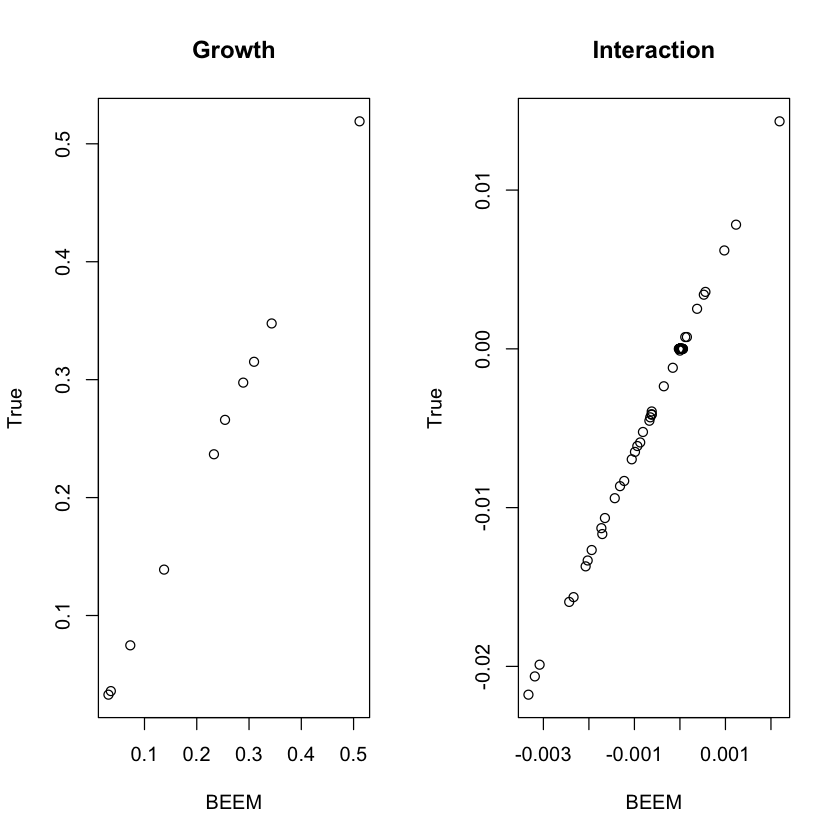

In [10]:
paramBEEM.nonSparse <- paramFromEM(res, counts, metadata, sparse=FALSE) ## compute parameter with non-sparse mode
par(mfrow = c(1,2))
plot(paramBEEM.nonSparse[paramBEEM$parameter_type=='growth_rate', 4], alpha, xlab='BEEM', ylab='True', main='Growth')
plot(paramBEEM.nonSparse[paramBEEM$parameter_type!='growth_rate', 4], c(beta), xlab='BEEM', ylab='True', main='Interaction')